# Metro Project

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from funcs import *
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from libpysal import weights
import networkx as nx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Getting county list

In [2]:
fips_path = "data/state_and_county_fips_master.csv"
md_counties = ["Prince George's County", "Montgomery County"]
va_counties = ["Arlington County", "Alexandria city", "Fairfax County", "Fairfax city", "Falls Church city"]
states = ["MD", "DC", "VA"]

md_codes = get_county_codes(fips_path, ["MD"], md_counties)
va_codes = get_county_codes(fips_path, ["VA"], va_counties)

### Getting existing network

In [3]:
dcs_df = load_shapefile("data/real_transit/DC_Streetcar_Routes.shp").to_crs(epsg=3857)
dcs_df["color"] = 'brown'
marc_df = load_shapefile("data/real_transit/Maryland_Transit_-_MARC_Train_Lines.shp").to_crs(epsg=3857)
marc_df["color"] = marc_df["Rail_Name"].apply(lambda a: '#EFAD1D' if 'Brunswick' in a else '#F15828' if 'Camden' in a else '#C71F3E')
wmata_df = load_shapefile("data/real_transit/Metro_Lines_Regional.shp").to_crs(epsg=3857)
wmata_df["color"] = wmata_df["NAME"].apply(lambda a: 
    '#F9921D' if 'orange' in a else 
    '#A1A3A1' if 'silver' in a else 
    '#E41838' if 'red' in a else
    '#FED201' if 'yellow' in a else
    '#01A850' if 'green' in a else
    '#0077C1')
vre_df = load_shapefile("data/real_transit/Virginia_Railway_Express_Routes.shp").to_crs(epsg=3857)
vre_df["color"] = vre_df["RAILWAY_NM"].apply(lambda a: '#156DB4' if 'Manassas' in a else '#DD3534')
pl_df = load_shapefile("data/real_transit/PurpleLineAlignment.shp").to_crs(epsg=3857)
pl_df["color"] = "#793390"

In [4]:
'''md_df = load_shapefile("data/md/tl_2023_24_tabblock20.shp")
md_df = md_df[md_df["COUNTYFP20"].isin(md_codes.tolist())].copy()
va_df = load_shapefile("data/va/tl_2023_51_tabblock20.shp")
va_df = va_df[va_df["COUNTYFP20"].isin(va_codes.tolist())].copy()
dc_df = load_shapefile("data/dc/tl_2023_11_tabblock20.shp")
df = pd.concat([md_df, va_df, dc_df], ignore_index=True)
df = gpd.GeoDataFrame(df)
df.to_crs("EPSG:4326", inplace=True)
df["SID"] = df.index
df["INTPTLON20"] = df["INTPTLON20"].astype(float)
df["INTPTLAT20"] = df["INTPTLAT20"].astype(float)
df["NEIGHBORS"] = None
df = compute_transit_potential(df)
save_geojson(df, "data/complete_region_df.geojson")
df = load_geojson("data/complete_region_df.geojson")
dc_df = load_shapefile("data/dc/tl_2023_11_tabblock20.shp")
extremities = [df["INTPTLON20"].min(), df["INTPTLAT20"].min(), df["INTPTLON20"].max(), df["INTPTLAT20"].max()]
extremities_dc = [dc_df["INTPTLON20"].min(), dc_df["INTPTLAT20"].min(), dc_df["INTPTLON20"].max(), dc_df["INTPTLAT20"].max()]
df_map = df.to_crs(epsg=3857)
ex_map = np.array([df_map.centroid.x.min(),df_map.centroid.y.min(),df_map.centroid.x.max(),df_map.centroid.y.max()])
np.save("data/ex_map.npy", ex_map)
df_map_dc = dc_df.to_crs(epsg=3857)
ex_map_dc = np.array([df_map_dc.centroid.x.min(),df_map_dc.centroid.y.min(),df_map_dc.centroid.x.max(),df_map_dc.centroid.y.max()])
np.save("data/ex_map_dc.npy", ex_map_dc)'''

ex_map = np.load("data/ex_map.npy")
ex_map_dc = np.load("data/ex_map_dc.npy")

In [5]:
'''df["point_likelihood"] = df["transit_potential"]
l = list(set(get_points(df, extremities)))
points = gpd.GeoDataFrame(df[df['SID'].isin(l)])
save_geojson(points, "data/graph_points.geojson")'''
points = load_geojson("data/graph_points.geojson")
combined_df_dc = load_geojson("data/dc/non-population-points/combined_df.geojson")
combined_df_md = load_geojson("data/md/non-population-points/combined_df.geojson")
combined_df_va = load_geojson("data/va/non-population-points/combined_df.geojson")
points = reset_and_concat(points, combined_df_dc, combined_df_md, combined_df_va)
points = points["geometry"]
df_points = gpd.GeoDataFrame(geometry=points.centroid).drop_duplicates().reset_index(drop=True)
df_points = df_points.to_crs(3857)

C:\Users\srjnk\AppData\Local\Temp\ipykernel_11820\1780059450.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_points = gpd.GeoDataFrame(geometry=points.centroid).drop_duplicates().reset_index(drop=True)


## Create Network

### KDE Heatmap

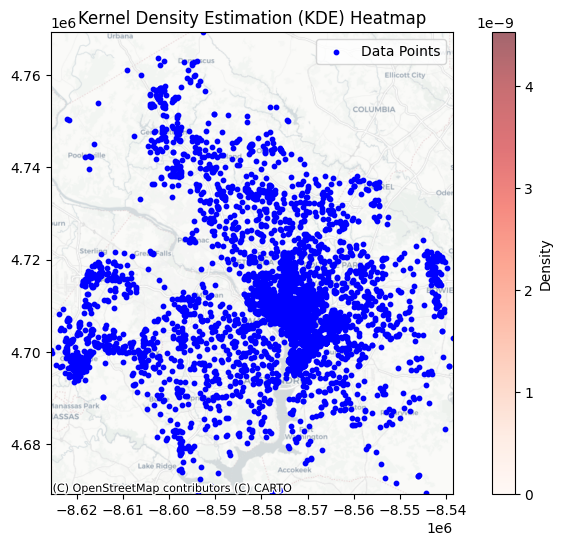

In [6]:
kde = plot_kde_heatmap(df_points)

### Gabriel Network

In [7]:
pts_array = np.array(list(zip(df_points.geometry.x, df_points.geometry.y)))
gabriel = weights.Gabriel.from_dataframe(df_points, use_index=True, silence_warnings=True)
network = gabriel.to_networkx()
gabriel_contracted, new_positions = contract_louvain_communities_with_positions(
    network, {n: pts_array[n] for n in network.nodes()}, 0.03
)

c:\Users\srjnk\Documents\cmsc725_wmata_map\venv\Lib\site-packages\libpysal\weights\gabriel.py:145: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  return cls(point_array, ids=ids, **kwargs)


In [8]:
assign_edge_weights(gabriel_contracted, new_positions)
gabriel_contracted = remove_isolated_nodes(gabriel_contracted)
save_graph_to_geojson(gabriel_contracted, new_positions, "data/output/network.geojson")

c:\Users\srjnk\Documents\cmsc725_wmata_map\venv\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


c:\Users\srjnk\Documents\cmsc725_wmata_map\venv\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


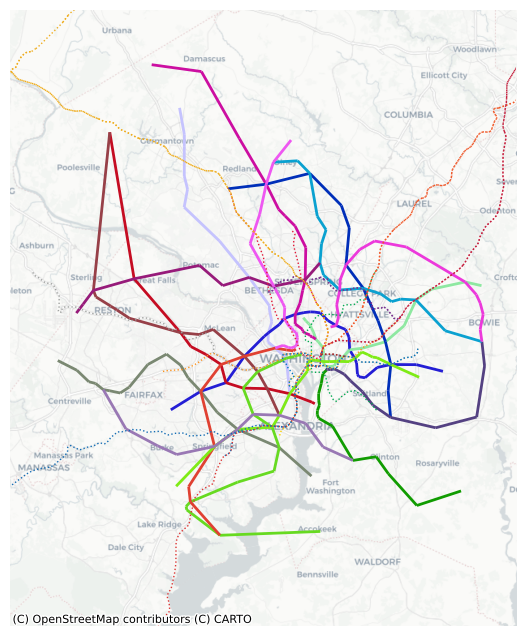

In [103]:
lines, traversed_edges, complete_traversed_edges = perform_walks(
    gabriel_contracted, new_positions, num_walks=20, 
    min_distance=35000, max_distance=50000, traversed_edges=set(), complete_traversed_edges=[])
for i in range(4):
    lines, traversed_edges, complete_traversed_edges = replace_lowest_scoring_walk(
        lines, new_positions, kde, gabriel_contracted, traversed_edges, complete_traversed_edges, 
        min_distance=35000, max_distance=50000, radius=700)
def plot_network(network, positions, bounds, labels=False, **kwargs):
    ax = wmata_df.plot(figsize=(8,8), color=wmata_df.color, linestyle='dotted', linewidth=1)
    pl_df.plot(ax=ax, color=pl_df.color, linestyle='dotted', linewidth=1)
    marc_df.plot(ax=ax, color=marc_df.color, linestyle='dotted', linewidth=1)
    vre_df.plot(ax=ax, color=vre_df.color, linestyle='dotted', linewidth=1)
    dcs_df.plot(ax=ax, color=dcs_df.color, linestyle='dotted', linewidth=1)
    #nx.draw(network, positions, ax=ax, node_size=5, node_color="b", edge_color="black", **kwargs)
    ax.set_axis_off()
    if labels:
        for node, (x, y) in positions.items():
            label = str(node)
            if True:
                label += f"\n({round(x/1e6,3)},{round(y/1e6,3)})"
            if node in network.nodes and x > bounds[0] and x < bounds[2] and y > bounds[1] and y < bounds[3]:
                ax.text(x, y, label, fontsize=7, ha='center', va='center', color='darkred', zorder=10)

    if labels:
        for u, v, data in network.edges(data=True):
            x1, y1 = positions[u]
            x2, y2 = positions[v]
            mx, my = (x1 + x2) / 2, (y1 + y2) / 2
            weight = data.get('weight', None)
            if weight is not None and mx > bounds[0] and mx < bounds[2] and my > bounds[1] and my < bounds[3]:
                ax.text(mx, my, f"{weight:.1f}", fontsize=7, color='green', ha='center', va='center', zorder=10)
    ax.set_xlim([bounds[0],bounds[2]])
    ax.set_ylim([bounds[1],bounds[3]])
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    return ax
ax=plot_network(gabriel_contracted, new_positions, ex_map, width=0.5, alpha=0.5)
ax=plot_walks(gabriel_contracted, new_positions, lines, ax, kde, ex_map)

status = mark_station_nodes(lines,gabriel_contracted,new_positions,min_station_dist=1000)
save_lines_to_geojson(lines, gabriel_contracted, new_positions, kde, "data/output/lines_naive.geojson", status)

In [ ]:
#ax=plot_network(gabriel_contracted, new_positions, ex_map, width=0.5, alpha=0.5)
#ax=plot_walks(gabriel_contracted, new_positions, lines, ax, kde, ex_map)
# test

c:\Users\srjnk\Documents\cmsc725_wmata_map\venv\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


## Align Transit Lines to Roadways

To better mimic real-world construction, we will align the generated transit lines to the existing road network using the road shapefiles for Maryland, DC, and Virginia.

In [26]:
# Load road network shapefiles for MD, DC, and VA
#md_roads = load_shapefile('data/md/roads/Maryland_Road_Centerlines_-_Comprehensive.shp').to_crs(epsg=3857)
#dc_roads = load_shapefile('data/dc/roads/Roadway_SubBlock.shp').to_crs(epsg=3857)
#va_roads = load_shapefile('data/va/roads/SDE_VDOT_RTE_MASTER_LRS.shp').to_crs(epsg=3857)

# Combine all roads into a single GeoDataFrame
all_roads = pd.concat([md_roads, dc_roads, va_roads], ignore_index=True)
all_roads = gpd.GeoDataFrame(all_roads)

'''# Visualize the road network and the generated transit lines
ax = all_roads.plot(figsize=(10, 10), color='gray', linewidth=0.5, alpha=0.5)
for line in lines:
    coords = [new_positions[n] for n in line if n in new_positions]
    if len(coords) > 1:
        xs, ys = zip(*coords)
        ax.plot(xs, ys, color='red', linewidth=2, alpha=0.8)
plt.title('Transit Lines Overlaid on Road Network')
plt.axis('off')
plt.show()'''

"# Visualize the road network and the generated transit lines\nax = all_roads.plot(figsize=(10, 10), color='gray', linewidth=0.5, alpha=0.5)\nfor line in lines:\n    coords = [new_positions[n] for n in line if n in new_positions]\n    if len(coords) > 1:\n        xs, ys = zip(*coords)\n        ax.plot(xs, ys, color='red', linewidth=2, alpha=0.8)\nplt.title('Transit Lines Overlaid on Road Network')\nplt.axis('off')\nplt.show()"

### Snap Transit Lines to Road Network

To ensure transit lines follow the roadways, we can snap each segment of the transit line to the nearest road segment. This can be done using spatial joins or nearest neighbor queries.

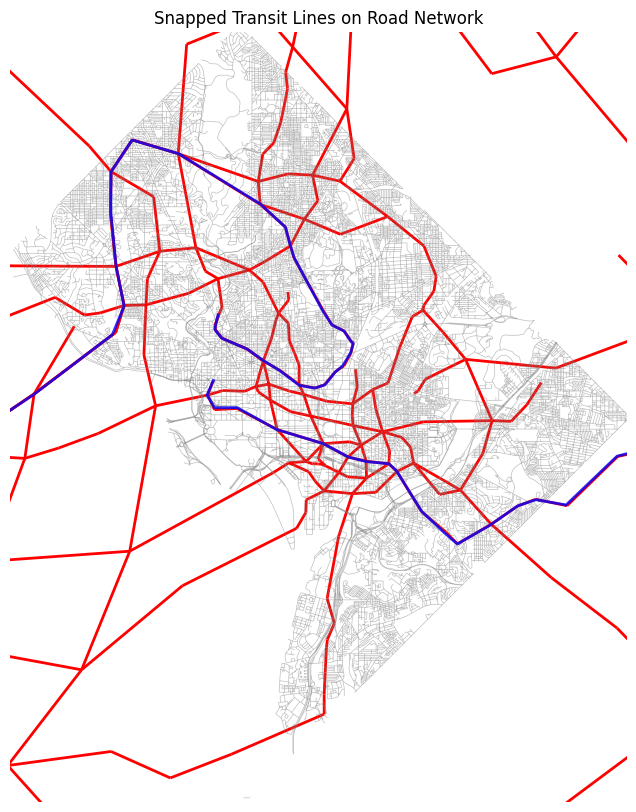

In [28]:


# Visualize snapped lines over the road network
ax = dc_roads.plot(figsize=(10, 10), color='gray', linewidth=0.5, alpha=0.5)
for snapped in snapped_lines:
    if len(snapped) > 1:
        xs, ys = zip(*snapped)
        ax.plot(xs, ys, color='blue', linewidth=2, alpha=0.8)
for walk in lines:
    walk_edges = [(walk[j], walk[j + 1]) for j in range(len(walk) - 1)]
    nx.draw_networkx_edges(
        gabriel_contracted,
        new_positions,
        edgelist=walk_edges,
        edge_color='red',
        width=2,
        ax=ax,
    )
ax.set_xlim([ex_map_dc[0],ex_map_dc[2]])
ax.set_ylim([ex_map_dc[1],ex_map_dc[3]])
plt.title('Snapped Transit Lines on Road Network')
plt.axis('off')
plt.show()

## Genetic

In [140]:
import pickle
%sx rm pickle/*
with open("pickle/graph.pkl", "wb") as f:   
    pickle.dump(gabriel_contracted, f)
with open("pickle/positions.pkl", "wb") as f:   
    pickle.dump(new_positions, f)
with open("pickle/kde.pkl", "wb") as f:   
    pickle.dump(kde, f)
with open("pickle/ex_map_dc.pkl", "wb") as f:   
    pickle.dump(ex_map_dc, f)
%sx python genetic.py
with open("pickle/best_routes.pkl", "rb") as f:   
    best_routes = pickle.load(f)
with open("pickle/best_score.pkl", "rb") as f:   
    best_score = pickle.load(f)
with open("pickle/log.pkl", "rb") as f:   
    log = pickle.load(f)
status = mark_station_nodes(best_routes,gabriel_contracted,new_positions,min_station_dist=1000)
save_lines_to_geojson(best_routes, gabriel_contracted, new_positions, kde, "data/output/lines_genetic.geojson", status)

c:\Users\srjnk\Documents\cmsc725_wmata_map\venv\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
